## Cours GEI723, Jean Rouat - Automne 2020 - Assistant: Ahmad El Ferdaoussi

Ce notebook est une introduction rapide aux fonctionnalités de Brian2 qui sont nécessaires pour la résolution du Problème 1 du cours. Il est basé sur les trois tutoriels de Brian2 disponibles sur https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html qui sont aussi sous forme de notebooks. Il est fortement recommandé de suivre ces trois tutoriels pour bien vous familiariser avec Brian2. 

On commence par importer Brian2 et activer le traçage de graphiques dans le notebook. Si vous utilisez un terminal au lieu d'un notebook, il faut faire «plt.show()» à la fin des plots au lieu de «%matplotlib inline» au début.

In [2]:
import numpy as np
from brian2 import *
%matplotlib inline

## Partie I: Unités

Brian2 a un système d'unités qui permet de faire des opérations avec des quantités ayant des unités.

Les unités implémentées peuvent être trouvées ici: https://brian2.readthedocs.io/en/stable/user/units.html

In [3]:
a = 1 * second
b = 10 * ms
a+b

1.01 * second

Pour obtenir une quantité sans unités, on divise par l'unité souhaitée.

In [4]:
a / second

1.0

In [5]:
a / ms

1000.0

Si on essaie de faire des opérations sur des unités non compatibles, on a une erreur!

In [7]:
c = 6 * Hz
(a/second) + (c/Hz)

7.0

Quand on a une erreur, il est utile de lire le traceback de bas en haut pour savoir de quoi il s'agit et retrouver la ligne coupable.

## Partie II: Neurones

Les neurones dans Brian2 sont définis à l'aide de leurs équations différentielles. Brian2 offre la possibilité de les écrire directement.
Définissons un modèle simple de type intégration et décharge.

In [11]:
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

Les équations différentielles s'écrivent de façon assez intuitive. Chaque ligne définit une nouvelle variable propre au groupe de neurone. À la fin de la ligne, il faut préciser l'unité de la variable. Ici, on définit la variable du potentiel (v), qui devrait normalement prendre l'unité volt (: v), mais en usage courant on omet l'unité du potentiel pour simplifier. Une quantité sans unité est définie avec «: 1».

Il faut que l'équation différentielle soit cohérente au niveau des unités à gauche et à droite. Essayez d'omettre la division par tau dans l'équation d'en haut, et roulez le code en bas!

In [12]:
G = NeuronGroup(1, eqs)
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.23s). [brian2.stateupdaters.base.method_choice]


Non, le message que vous voyez n'est pas une erreur, c'est Brian2 qui nous rappelle qu'on peut faire des choix de méthodes d'intégration numérique, et que vu qu'on n'a pas fait de choix, il l'a fait pour nous. Pour la suite, on choisira une méthode...

On a roulé une simulation pour une certaine durée à l'aide de la fonction run()... maintenant comment voir l'évolution du potentiel du neurone?

In [13]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
statemon = StateMonitor(G, 'v', record=True)

run(100*ms)

À quoi set start_scope()? Ça dit à Brian2 d'ignorer tous les objets qu'on a créés avant pour la prochaine simulation qu'on fait avec run(). En d'autres termes, run() simule tous les objets qui sont dans le présent scope.

Pour enregistrer l'évolution d'une variable de neurone, on utilise StateMonitor qui prend comme arguments: le groupe de neurones, la variable à monitorer, et quels neurones dans le groupe enregistrer. Ici, record=True signifie qu'on veut monitorer tous les neurones dans le groupe G. Dans de grosses simulations, il n'est pas judicieux de monitorer tous les neurones!

Dessinons le graphique du potentiel. StateMonitor nous donne accès à la courbe de potentiel du neurone 0 (statemon.v[0]), ainsi qu'au temps (statemon.t).

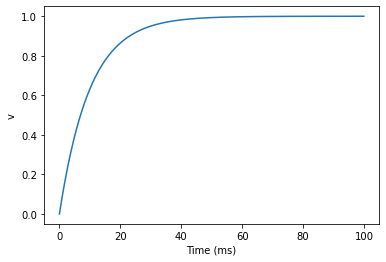

In [14]:
plot(statemon.t/ms, statemon.v[0])
xlabel('Time (ms)')
ylabel('v');

On peut rendre notre neurone plus complexe, en y ajoutant un seuil de décharge, une valeur de remise au repos, et une période réfractaire.

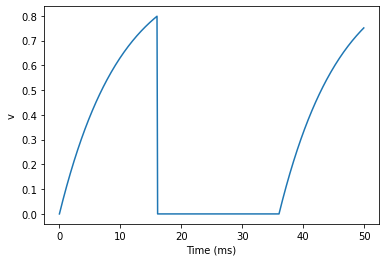

In [18]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', refractory=5*ms, method='exact')
statemon = StateMonitor(G, 'v', record=0)
run(50*ms)

plot(statemon.t/ms, statemon.v[0])
xlabel('Time (ms)')
ylabel('v');

Il semble que notre neurone a émit trois décharges. Comment peut-on avoir accès aux instants de décharge? C'est en utilisant les SpikeMonitor, de façon semblable aux StateMonitor.

SpikeMonitor enregistre tous les instants de décharge (spikemon.t) ainsi que les indices des neurones correspondants (spikemon.i).

In [19]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

print('Instants de décharge: %s' % spikemon.t[:])
print('Indices de neurones : %s' % spikemon.i[:])

Instants de décharge: [16. 37.] ms
Indices de neurones : [0 0]


Ce n'est pas intuitif comme résultat... Une façon de rendre ça plus utile est la fonction spike_trains() de SpikeMonitor, qui trie les instants suivant les neurones.

In [20]:
spikemon.spike_trains()

{0: array([16., 37.]) * msecond}

Dessinons les décharges sur le graphique du potentiel.

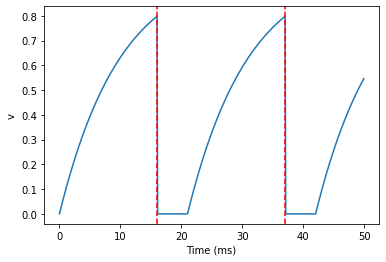

In [21]:
plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r')
xlabel('Time (ms)')
ylabel('v');

Simulons plusieurs neurones maintenant.

Pour avoir des résultats intéressants, initialisons le potentiel à l'instant t=0 de chaque neurone de façon aléatoire.

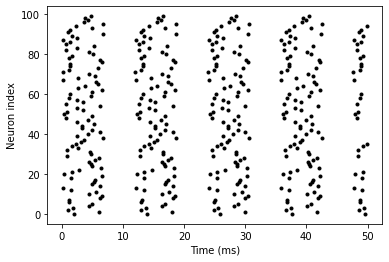

In [22]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

## Exercice 1: Neurone mystère

Regardez attentivement le fonctionnement du neurone ci-dessous. Il ressemble au modèle intégration et décharge précédent. Pouvez-vous expliquer exactement ce qui se passe?

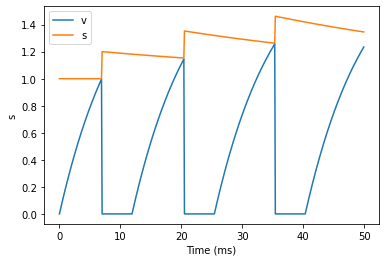

In [23]:
start_scope()

eqs = '''
dv/dt = (2-v)/(10*ms) : 1 (unless refractory)
ds/dt = (1-s)/(50*ms) : 1 
'''

reset_eqs = '''
v = 0
s += 0.2
'''

G = NeuronGroup(1, eqs, threshold='v>s', reset=reset_eqs, refractory=5*ms, method='exact')
G.s = 1
statemon = StateMonitor(G, ['v', 's'], record=0)
run(50*ms)

plot(statemon.t/ms, statemon.v[0], label='v')
plot(statemon.t/ms, statemon.s[0], label='s')
xlabel('Time (ms)')
ylabel('s')
legend();

## Partie 3: Synapses

Maintenant qu'on sait comment créer des neurones et les simuler, créons des synapses.

L'objet Synapses prend un NeuronGroup source et un NeuronGroup cible (qui peuvent être un seul et même). On connecte les synapses avec la méthode «Synapses.connect()» qui prend en argument les neurones pré- et post-synaptiques à connecter.

On peut aussi donner des instructions à faire lorsque le neurone pré- ou post-synaptique décharge. Ci-dessous, on dit à Brian2 d'augmenter le potentiel du neurone post-synaptique de 0.2 lorsque le neurone pré-synaptique décharge.



WARNING    "tau" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


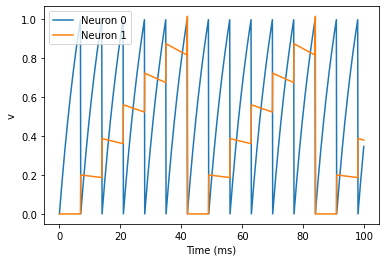

In [25]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

Ci-dessus, une décharge du neurone source a provoqué une augmentation de 0.2 du potentiel du neurone cible. Généralisons cela en définissant un poids pour la synapse.

Considérons 3 neurones cette fois-ci. Le premier est connecté aux deux autres.

On commence par définir une variable propre au groupe de synapses. On appelle cette variable w. L'instruction au moment de la décharge du neurone pré-synaptique peut maintenant être écrite tout simplement comme «on_pre='v_post += w'». Ici, v_post identifie la variable du potentiel du NEURONE, donc il est important de préciser s'il s'agit du neurone pré-synaptique ou du neurone post-synaptique. D'autre part, w identifie la variable du poids de la SYNAPSE, et donc il n'y a pas d'ambiguité à ce point-là.

Brian2 nous offre beaucoup de simplicité au niveau du code. Par exemple, le j dans la ligne «S.w = 'j\*0.2'» fait référence à l'indice du neurone post-synaptique. (Similairement, on peut utiliser la variable i pour identifier l'indice du neurone pré-synaptique). 

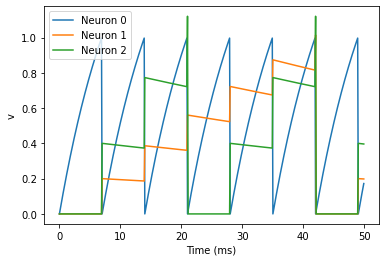

In [27]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.connect(i=1, j=2)
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

Il manque encore quelque chose! Ci-dessus, l'effet des synapses a été instantané. Introduisons donc des délais de propagation. Ceci ce fait avec l'attribut «delay» de Synapses, et on peut entrer des valeurs de toutes les différentes façons qu'on a vues jusqu'à présent.

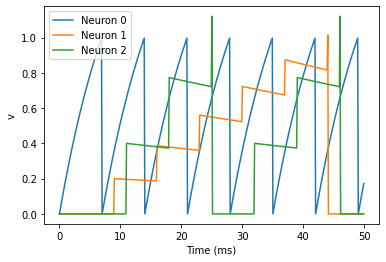

In [28]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

Explorons des possibilités de connexions plus complexes entre les neurones. Définissons d'abord une fonction qui va nous aider à visualiser la connectivité.

In [29]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Cible'])
    ylabel('Indice du neurone')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Indice du neurone source')
    ylabel('Indice du neurone cible')

On va connecter les synapses d'un même groupe de neurone de la façon suivante. Un neurone a une probabilité de 0.2 d'être connecté aux autres.

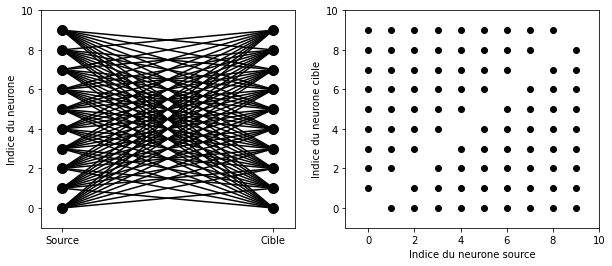

In [33]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

visualise_connectivity(S)

## Exercice 2: Connexions et distances

Faisons un petit exercice!

Le bout de code ci-dessous définit deux groupes de neurones de 10 chacun. Imaginons qu'il s'agit de deux couches parallèles et que la distance entre les deux couches est de 1. Considérons également que la distance entre deux neurones d'une seule colonne est égale à 1 également.

L'exercice consiste à connecter les neurones du premier groupe à ceux du deuxième groupe en faisant en sorte que la probabilité de connexion dépende de la distance entre le neurone source et le neurone cible. En d'autres termes, plus le neurone cible est loin, moins il y a de probabilité d'établir une synapse.

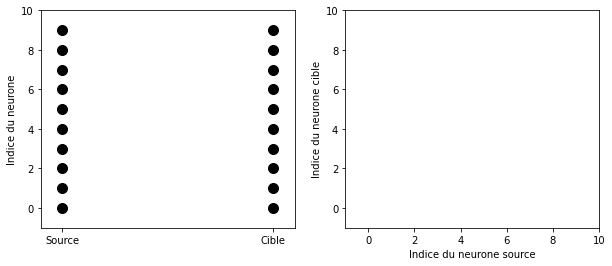

In [34]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
H = NeuronGroup(N, 'v:1')
S = Synapses(G, H)
S.connect()

visualise_connectivity(S)

On n'a montré ici qu'une façon de spécifier comment connecter les synapses. Il existe d'autres à découvrir dans le tutoriel 2 de Brian2.

## Partie 4: Simulation

Lorsqu'on appelle la fonction run(), Brian2 simule tous les objets dans le présent scope. Et si l'on voulait uniquement simuler quelques objets? Les objets Network permettent de faire cela.

Quand on simule un Network, uniquement les objets qui ont été mis dans le Network vont être simulés.

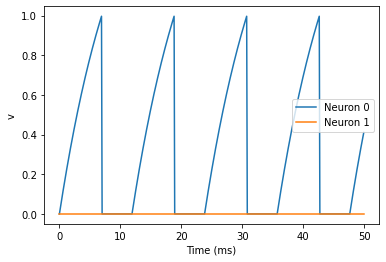

In [36]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I : 1
tau : second
'''

G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', refractory=5*ms, method='exact')

G.I[0] = 2
G.tau = 10 * ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=1)
S.w = 0.5
S.delay = 5 * ms

M = StateMonitor(G, 'v', record=True)


net = Network(G, M)
net.run(50*ms)



plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

Que se passe-t-il lorsqu'on lance des simulations successives dans Brian2? La nouvelle simulation reprend là où la dernière s'est arrêtée.

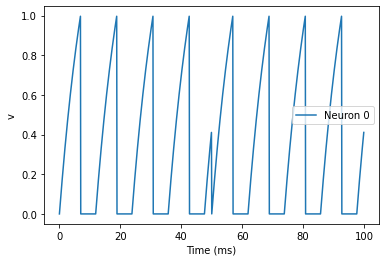

In [38]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I : 1
tau : second
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v = 0', refractory=5*ms, method='exact')

G.I = 2
G.tau = 10 * ms
G.tau = 10 * ms

M = StateMonitor(G, 'v', record=0)

run(50*ms)

G.v = 0

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
xlabel('Time (ms)')
ylabel('v')
legend();


Et si l'on veut lancer plusieurs simulations en faisant varier un paramètre? Pensons par exemple à faire varier la constante de temps du neurone. Une façon naïve de faire est de relancer toute la simulation (construction des objets, etc.) à chaque fois. Brian2 permet de faire plus efficace!

Faisons varier $\tau$ de 1ms à 10ms. Les méthodes net.store() et net.restore() des objets Network permettent de sauvegarder l'état d'un Network avant une simulation et de le restaurer par après en vue de lancer une simulation avec un $\tau$ différent.

Vous voyez que c'est assez rapide. Essayez de faire la même simulation de façon naïve. Est-ce que vous voyez une différence dans le temps de simulation?

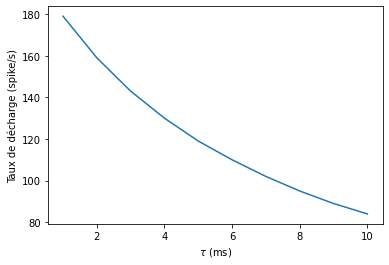

In [38]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I : 1
'''

tau_range = linspace(1, 10, 10)*ms

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
G.I = 2

M = SpikeMonitor(G)

# Sauvegarder l'état courant du Network
net = Network(G, M)
net.store()

output_rates=[]

for tau in tau_range:
    # Restaurer l'état original du Network
    net.restore()
    # On simule avec une nouvelle valeur de tau
    net.run(1*second)
    # Calculer le taux de décharge et l'ajouter à la liste
    output_rates.append(M.num_spikes/second)
    
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Taux de décharge (spike/s)');

Brian2 permet également d'avoir des entrées plus complexes. Par exemple, des entrées en décharges qui suivent une distribution de Poisson. Le troisième tutoriel de Brian2 présente ceci et d'autres choses. Assurez-vous de le faire, ainsi que les deux autres tutoriels!